---
title: Systematically Web Scrape Multiple Data Files From Websites
---

![010_001.png](../22_assets/images/010_001.png)
*Figure 1. Screenshot of Bixi open data*
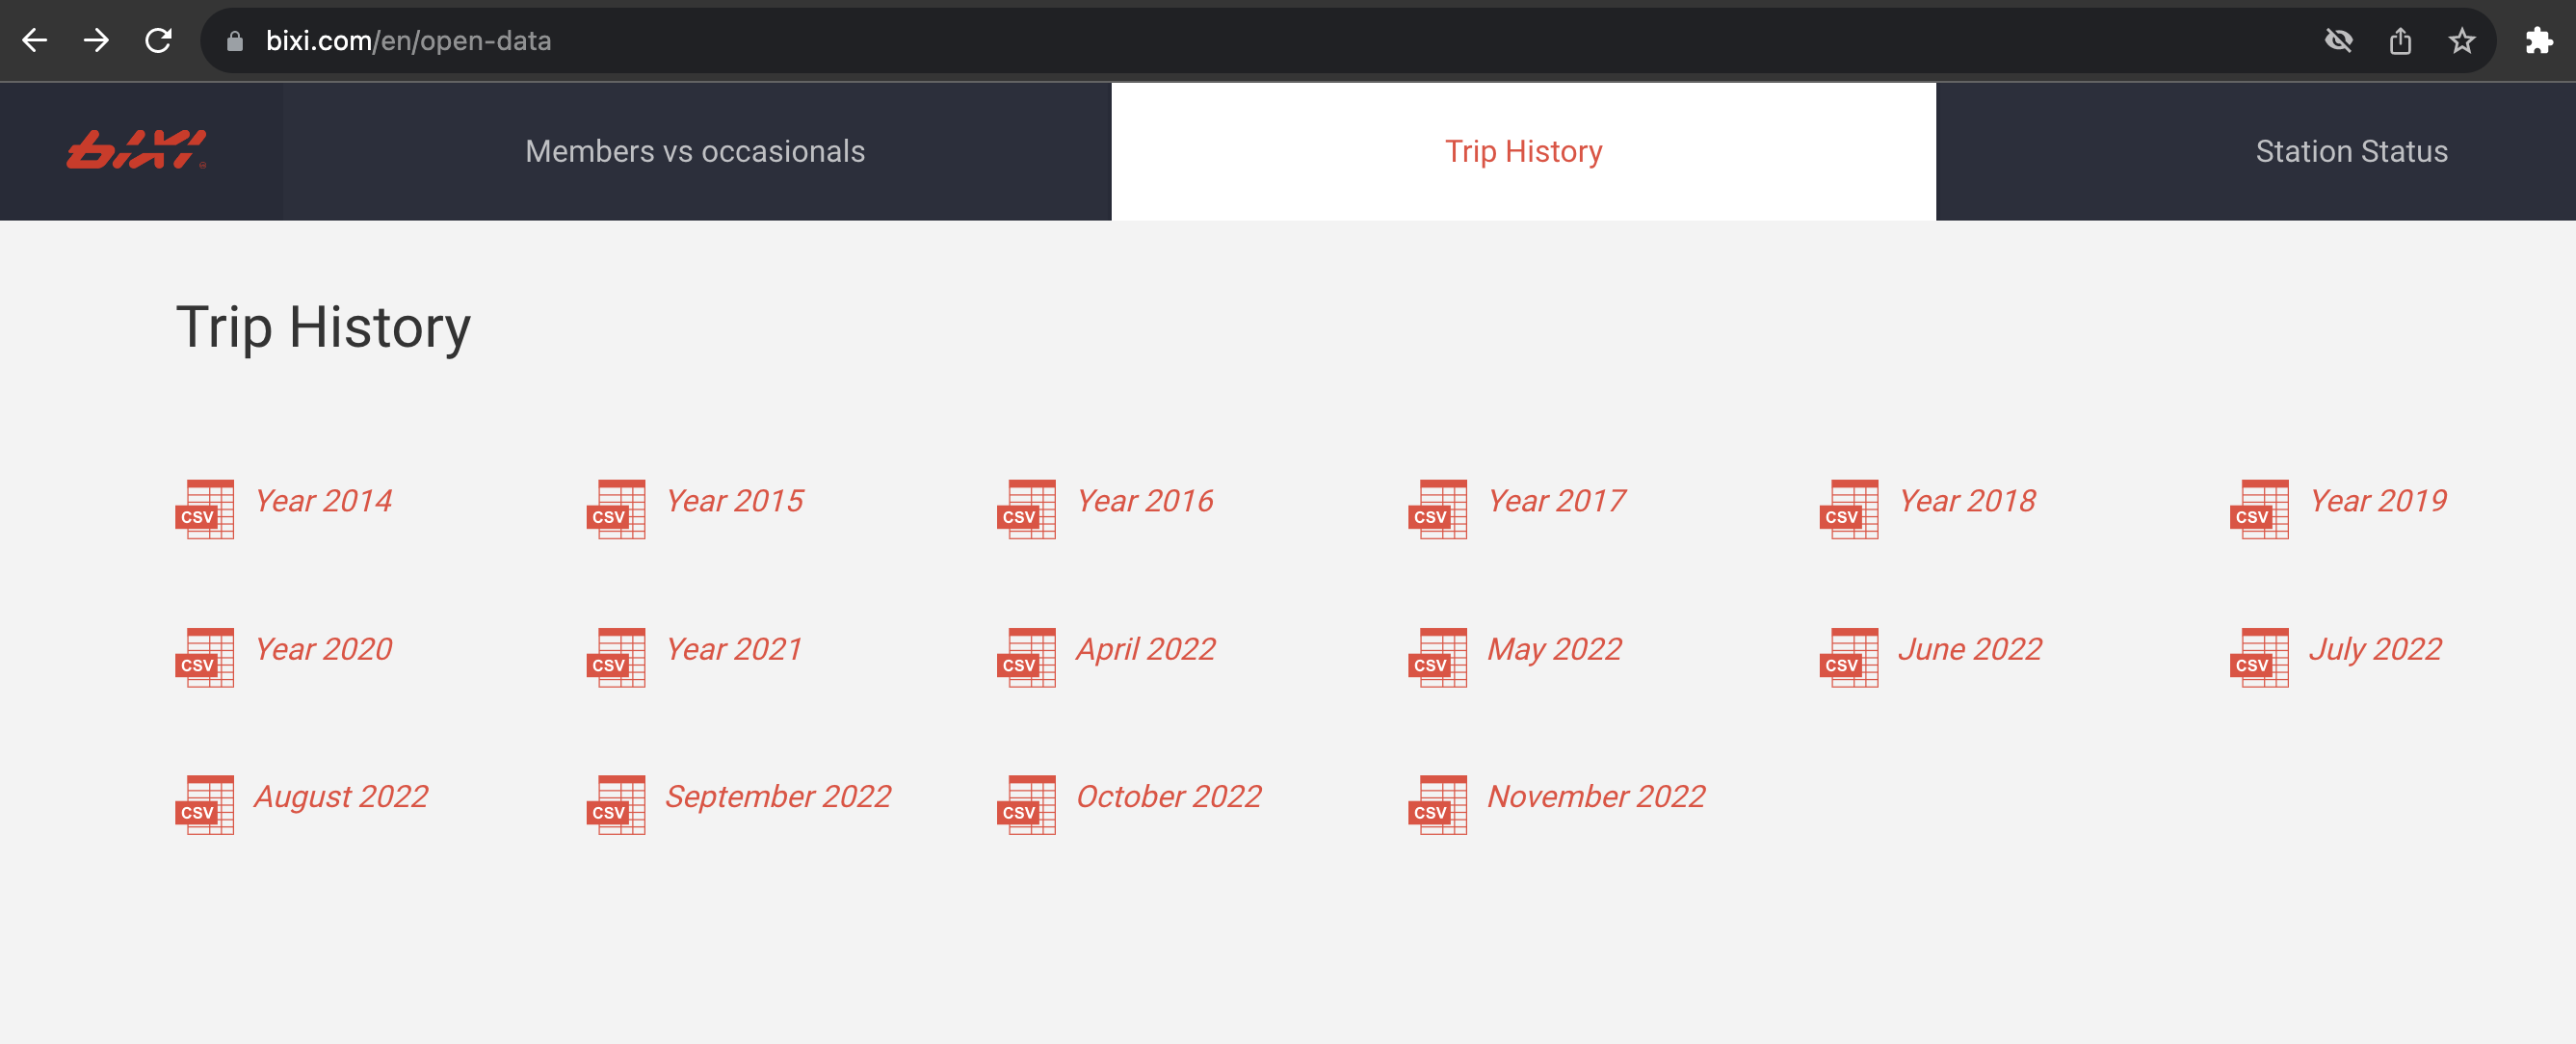

<!--TABLE OF CONTENTS-->
Table of Contents:
  - [Motivation and Introduction](#Motivation-and-Introduction)
  - [Part 1: Identify and Web Scrape Data Download URLs from Bixi](#Part-1:-Identify-and-Web-Scrape-Data-Download-URLs-from-Bixi)
    - [Send GET requests](#Send-GET-requests)
    - [Inspect Elements](#Inspect-Elements)
    - [Download and Filter URLs](#Download-and-Filter-URLs)
  - [Part 2: Download the Files from each URL, then Extract Data into Single Folder](#Part-2:-Download-the-Files-from-each-URL,-then-Extract-Data-into-Single-Folder)
    - [Download the Data](#Download-the-Data)
    - [Unzip the Data](#Unzip-the-Data)
  - [Conclusion and Next Steps](#Conclusion-and-Next-Steps)
  - [References and Acknowledgement](#References-and-Acknowledgement)

## Motivation and Introduction

Often times when collecting data for a project, we encounter consumer facing websites that do not have full Application Programming Interfaces (APIs) that allow for data to be accessed and downloaded in a programatic way.
What this usually means is that we as data scientists have to manually click the download buttons on a website and provide a directory for the file to be saved on a local drive.

For one or two files this is maneagable but as companies continue to publish more open data, it is not unusual to find websites such as the one shown above belonging to [Bixi](https://bixi.com/en/open-data), a bike-share company in the city of Montreal in the province of Quebec, Canada.

In the image above, we see a file for each year, with the most recent year having a file for each month. Downloading the data manually would mean having to repeatedly click download 16 times, not including the effort needed to consolidate the files later into a single data folder.

In this notebook, we explore a more systematic way to access and download all data links within a website using the `requests` and `BeautifulSoup` packages in Python.

The notebook is split into two parts:
- part 1: identify and web-scrape all data download URLs from the Bixi website
- part 2: using the web-scraped links, download the data files and  extract the data out of compressed ZIP files into a single folder.

Note that the downloaded data are usually stored in SQL databases managed using database management systems (DBMS) such as MySQL or AWS Athena, but are stored in a CSV file for the brevity of this notebook.

## Part 1: Identify and Web Scrape Data Download URLs from Bixi

We begin as most jupyter notebooks do, with importing required packages.

Notable packages here are the `requests` and `BeautifulSoup` packages:
- [`requests`](https://requests.readthedocs.io/en/latest/): an elegant and simple HTTP library for Python, built for human beings.
- [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/): a Python library for pulling data out of HTML and XML files.

In [1]:
# Packages for part 1
import pandas as pd # for general data processing
import requests # for scraping data from websites
from bs4 import BeautifulSoup # for converting scraped data into structured html

# Packages for part 2
import shutil # High level operation on files (example copying and removing)
import time # For timing and measuring progress of download
import numpy as np # For rounding digits
import datetime #For measuring time
import pytz #For defining timezone
import os # to examine local directory
import zipfile # for unzipping files

### Send GET requests

Before performing any web-scraping, the first step is to identify the website(s) from which to scrape from. For this notebook, the website where Bixi hosts its data was identified and stored in the `url` variable below.

In [2]:
# Store target website as a variable
# URL stands for Uniform Resource Locator, commonly known as web address
url = "https://www.bixi.com/en/open-data"

To gather data from a website, we will be using the GET method within the requests package.

In [3]:
# Send a GET request to gather a response
response = requests.get(
    url = url,
    auth = None,
    params = None
)

Note the `auth` and `params` arguments were set to `None` in this case as the Bixi website does not require any user authentication or any query arguments. These arguments are usually used when accessing APIs, such as the [Twitter API](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/User-Lookup/get_users_with_bearer_token.py).

An alternative but more encompassing method is the `request` method.

In [4]:
# Send a GET request to gather a response
response_alt = requests.request(
    "GET", # Specify 'GET' to retrieve a response from the website
    url,
    auth = None,
    params = None
)

Depending on access levels to a website, not all responses gathered are valid. The validity of a response can be determined using the response status code. 
- Response code 200 means a successful response
- Response codes 40X means an error has occured

The status code and its associated message can be examined using the below attributes:

In [5]:
print(f"Response status code: {response.status_code}, status: {response.reason}")

Response status code: 200, status: OK


The response status code and reason are usually helpful for troubleshooting more complex queries or errors.

In [6]:
# Alternatively, the `ok` attribute can also be used.
response.ok

True

Both the `get` and `request` methods return equivalent response objects.

In [7]:
print(type(response))
print(type(response_alt))
print(response.text == response_alt.text)

<class 'requests.models.Response'>
<class 'requests.models.Response'>
True


Then, we can use the `text` attribute of the response object to visually examine the contents of the response. As expected, the response text is a large text blob containing all the elements of the provided website. To maintain brevity, only the first 300 characters of the response were displayed below.

In [8]:
# Display first 300 characters of text blob
response.text[0:300]

'<!doctype html>\n<html class="no-js" lang="en" data-scrollbar>\n\t<head>\n\t\t<meta charset="utf-8">\n<meta name="viewport" content="width=device-width,initial-scale=1"/>\n<meta http-equiv="X-UA-Compatible" content="IE=Edge"/>\n\n<link rel="apple-touch-icon" sizes="57x57" href="/assets/favicon/apple-touch-ico'

### Inspect Elements

As data scientists, most of the contents within the response object are not useful as they pertain to the design and layout of the website. How then do we identify the specific components that contain the data we are seeking to scrape?

To answer this, we may perform an element inspection on the specific desired part of a website using a web browser. Right click on the element containing the data ("Year 2021" below), then select "Inspect".

*Note*: the web browser used was Google Chrome

![010_002.png](../22_assets/images/010_002.png)
*Figure 2. Accessing Element Inspector Within a Webpage*

In the element inspector that appears, the element and its corresponding code block were highlighted. In the code block, the URL embedded within the element can be identified after the `a` HTML tag. Clicking on this URL will lead to the download of a zip file containing Bixi bicycle trips data. 

The other data containing urls were observed to be above and below the highlighted code block. For this case, note that all the other data URLs contain the string 'amazonaws' as a common pattern. This means that the data is actually stored on an Amazon S3 bucket. To facilitate the web-scraping of all URLs that contain data, the string pattern 'amazonaws' will be used to identify such urls from the response object downloaded earlier. 

*Side note*: although there is another Python package that specializes in dealing with Amazon S3 buckets, [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), the method presented in this notebook is more generizable to other data stored outside of Amazon S3. 

![010_003.png](../22_assets/images/010_003.png)
*Figure 3. Inspecting Elements Within a Webpage
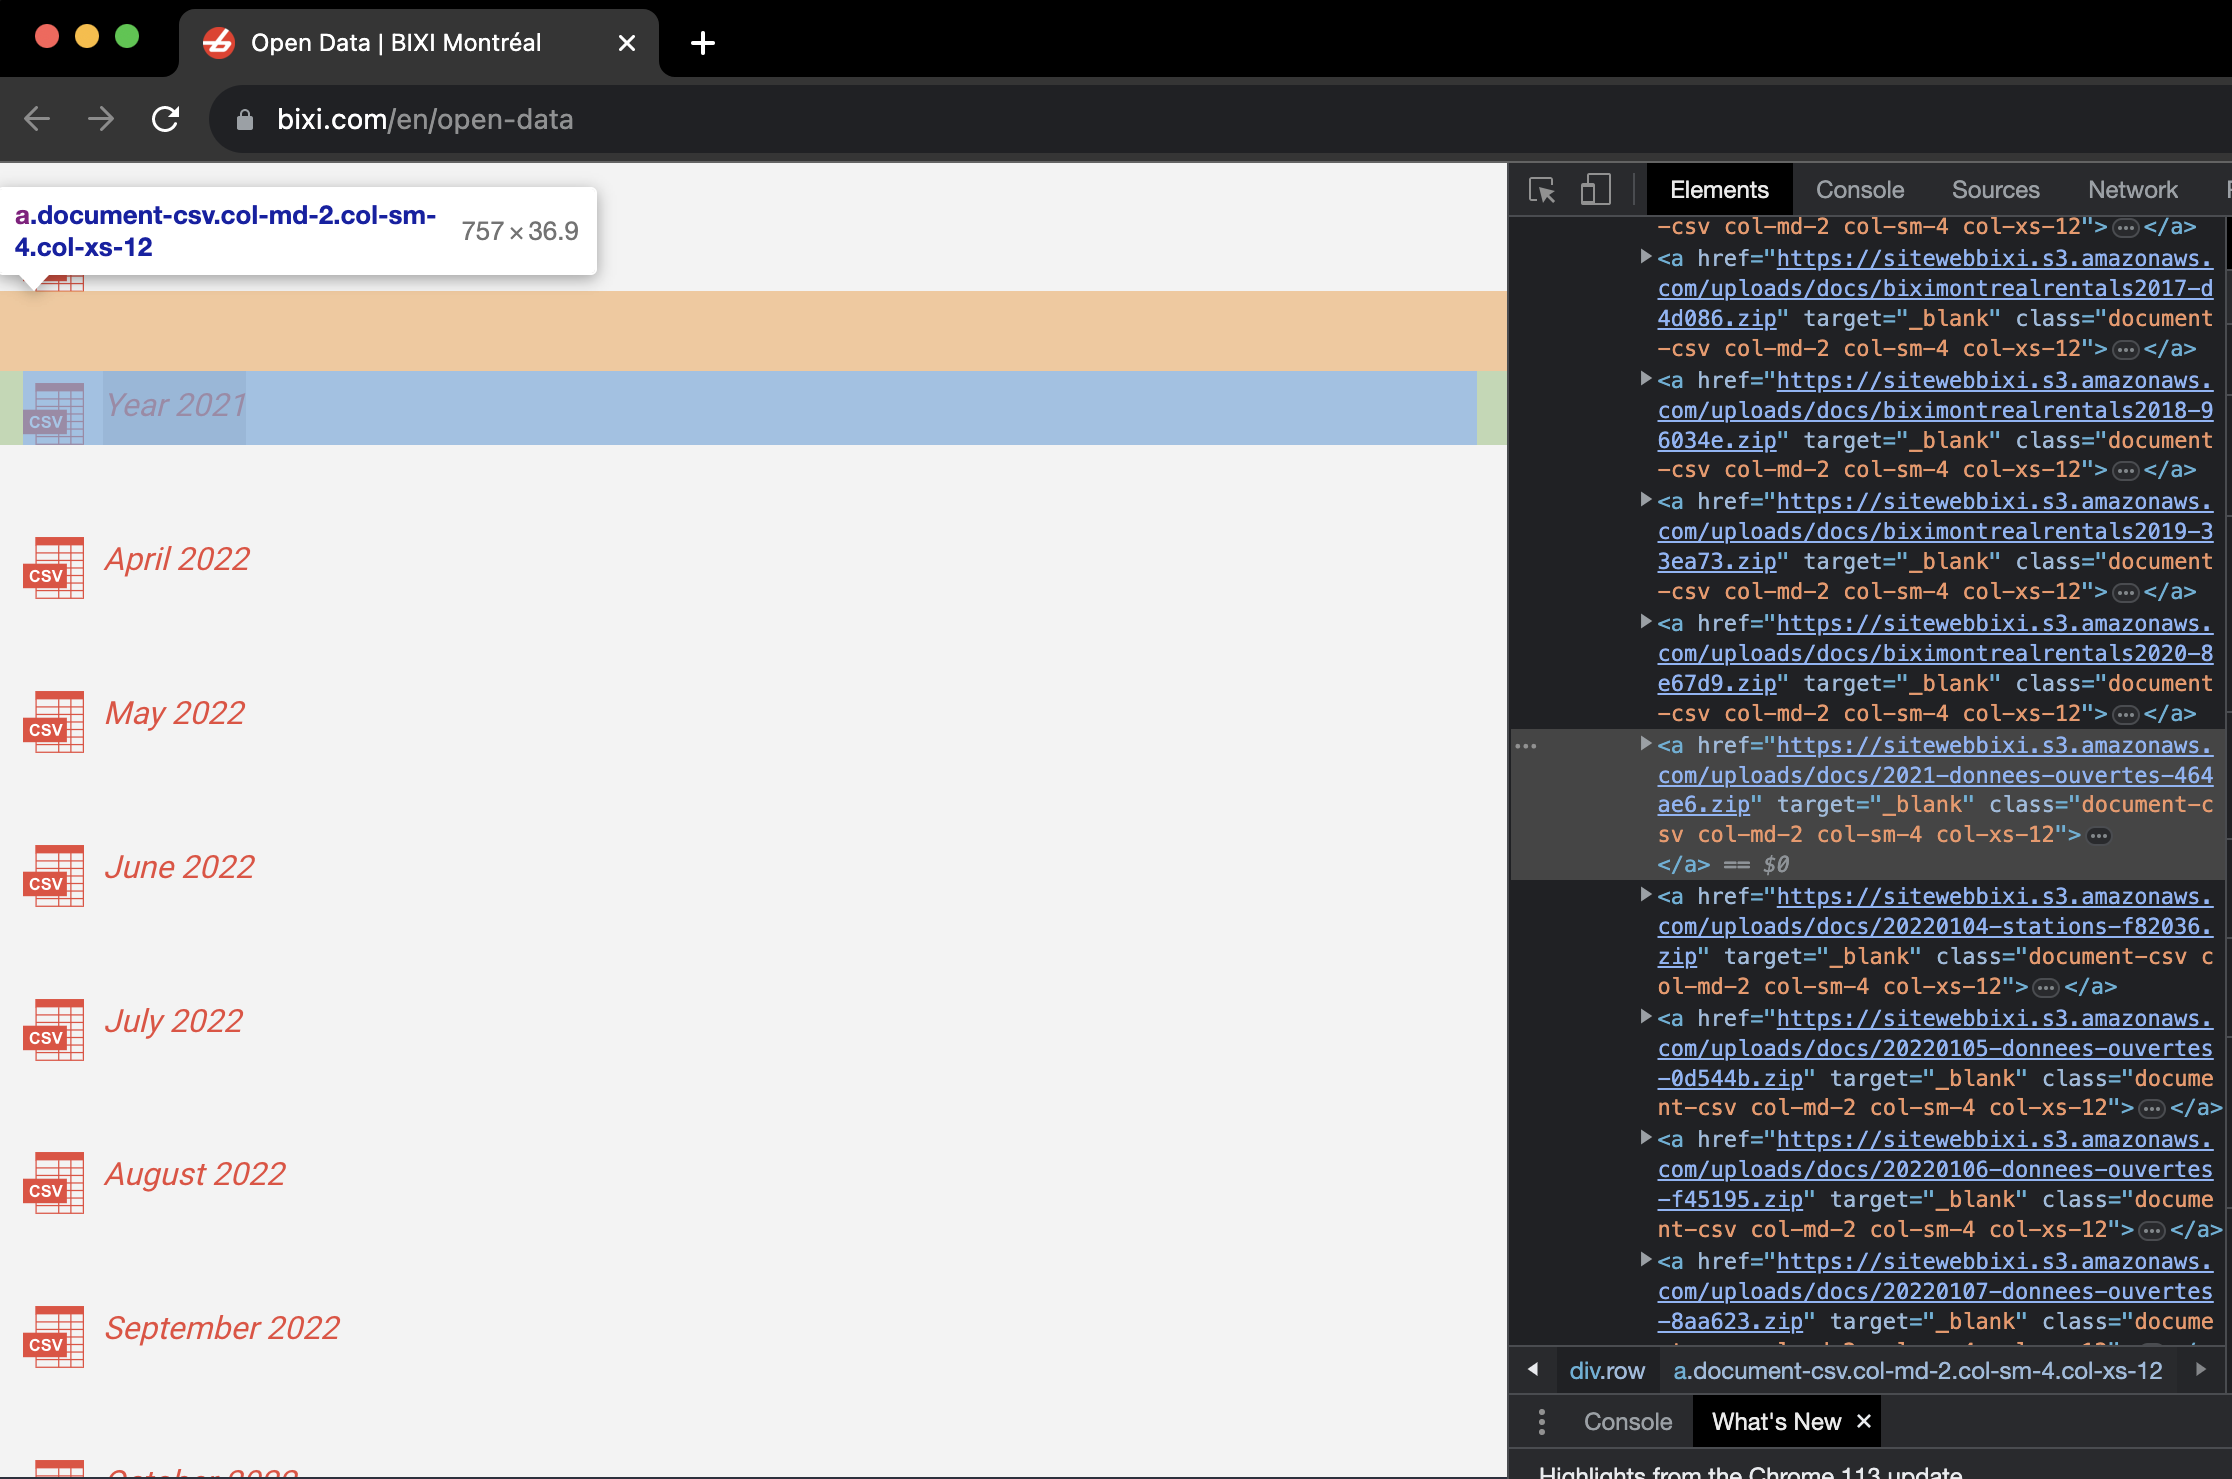

### Download and Filter URLs

After identifying `amazonaws` as the string pattern that uniquely identifies data download URLs among the web-scraped text blob, the next step is to use the BeautifulSoup package to transform the text blob into structured HTML(soup object) for querying.

In [9]:
# Store the string pattern as a variable
url_string_pattern = 'amazonaws'

# Convert response text blob into structured HTML format
soup = BeautifulSoup(response.text, 'html.parser')

# Check type of converted response text
print(f"Converted response has type: {type(soup)}")

Converted response has type: <class 'bs4.BeautifulSoup'>


As the soup object is a collection of structured HTML tags, the HTML tag `a` can be used to identify all urls within the soup object.

In [10]:
# Find all tags that are 'a' using the find_all method
url_tags = soup.find_all('a')

As seen below, the HTML tag `a` along with any URLs have been extracted into a list. Note a total of 99 `a` tags were found.

In [11]:
print(f"Tag object has type: {type(url_tags[0])}")
print("")

# Visually examine first 5 tags
for index, tag in enumerate(url_tags[0:5]):
    print(f"Tag {index + 1} / {len(url_tags)}: {tag}")

Tag object has type: <class 'bs4.element.Tag'>

Tag 1 / 99: <a class="logo" href="/en"></a>
Tag 2 / 99: <a class="altLang" href="https://www.bixi.com/fr/donnees-ouvertes">Français</a>
Tag 3 / 99: <a href="https://www.bixi.com/en/network-info">Network info</a>
Tag 4 / 99: <a href="https://www.bixi.com/en/contact-us">Contact us</a>
Tag 5 / 99: <a class="icon-facebook social" href="https://www.facebook.com/BIXImontreal/" target="_blank"></a>


Then, the url within each tag must be extracted. This was done by using the `get` method on each tag within the `url_tags` list. Within the `get` method, the string `href` was used to  was used to identify the urls within each tag.

In [12]:
# Initiate a blank list to store extracted url
url_list = list()

# Loop through each tag to extract urls using get method
for tag in url_tags:
    url_list.append(tag.get('href'))

The URLs from each tag have been extracted and stored in the list `url_list` as seen below.

In [13]:
# Visual examination of the urls extracted from tags
print(f"Extracted urls from tags:")

# Visually examine first 5 urls extracted from tags
for index, url in enumerate(url_list[0:5]):
    print(f"URL {index+1} / {len(url_list)} : {url}")

Extracted urls from tags:
URL 1 / 99 : /en
URL 2 / 99 : https://www.bixi.com/fr/donnees-ouvertes
URL 3 / 99 : https://www.bixi.com/en/network-info
URL 4 / 99 : https://www.bixi.com/en/contact-us
URL 5 / 99 : https://www.facebook.com/BIXImontreal/


Finally, the last step is to filter the list for only the URLs that lead to data download, which in this case are URLs that contain the string pattern `amazonaws`. To do this, the `url_list` was first converted into a DataFrame object using pandas, which allows for string filtering using the `str.contains` method.

In [14]:
# To use pandas str.contains() method, the list of extracted urls was first converted into a DataFrame
url_df = pd.DataFrame(
    url_list, 
    columns = ['extracted_url']
)

# Examine the extracted urls
display(url_df.head())

,extracted_url
0,/en
1,https://www.bixi.com/fr/donnees-ouvertes
2,https://www.bixi.com/en/network-info
3,https://www.bixi.com/en/contact-us
4,https://www.facebook.com/BIXImontreal/


After converting the list of URLs into a DataFrame, `pandas` was used to remove any null values and keep only urls that contain the string pattern `amazonaws`.

In [15]:
# Drop any null values since null values would mean no urls
url_df.dropna(inplace = True)

# Define filter condition to keep only urls that contain the string pattern
# Apply lower case first before performing a string match
cond1 = url_df['extracted_url'].str.lower()\
        .str.contains(url_string_pattern)

# Use the defined condition to filter the extracted url list
url_df = url_df.loc[cond1].reset_index(drop = True).copy()

To summarize, starting from the Bixi website, we have identified and gathered all 16 data download urls within the BIXI website without having to visually identify and click on each link within the website. In part 2, we will explore how to download the data contained within each of the 16 urls and unzip the data files into a single folder.

In [16]:
print(f"The number of data download urls extracted is {url_df.shape[0]}, which is 100% of all data download urls visible on the Bixi website.")

# Visually examine first 5 data download urls
print("Visually examine first 5 filtered urls")
for index, url in enumerate(url_df['extracted_url'].to_list()[0:5]):
    print(f"URL {index+1} / {url_df.shape[0]} : {url}")

The number of data download urls extracted is 16, which is 100% of all data download urls visible on the Bixi website.
Visually examine first 5 filtered urls
URL 1 / 16 : https://sitewebbixi.s3.amazonaws.com/uploads/docs/biximontrealrentals2014-f040e0.zip
URL 2 / 16 : https://sitewebbixi.s3.amazonaws.com/uploads/docs/biximontrealrentals2015-69fdf0.zip
URL 3 / 16 : https://sitewebbixi.s3.amazonaws.com/uploads/docs/biximontrealrentals2016-912f00.zip
URL 4 / 16 : https://sitewebbixi.s3.amazonaws.com/uploads/docs/biximontrealrentals2017-d4d086.zip
URL 5 / 16 : https://sitewebbixi.s3.amazonaws.com/uploads/docs/biximontrealrentals2018-96034e.zip


## Part 2: Download the Files from each URL, then Extract Data into Single Folder

In part two, our focus will be on using the gathered data download URLs to download and unzip the data into a folder on the local system. Further steps can be taken to send the extracted data into a Structured Query Language (SQL) database, but that is beyond the scope of this notebook.

### Download the Data

We begin with extracting the file name from each url link using regular expression (regex).

In [17]:
# Using the string split method, split the url into separate chunks
split_df = url_df['extracted_url'].str.lower()\
            .str.split('/', expand = True)

# Visually examine the first 5 rows
display(split_df.head())

,0,1,2,3,4,5
0,https:,,sitewebbixi.s3.amazonaws.com,uploads,docs,biximontrealrentals2014-f040e0.zip
1,https:,,sitewebbixi.s3.amazonaws.com,uploads,docs,biximontrealrentals2015-69fdf0.zip
2,https:,,sitewebbixi.s3.amazonaws.com,uploads,docs,biximontrealrentals2016-912f00.zip
3,https:,,sitewebbixi.s3.amazonaws.com,uploads,docs,biximontrealrentals2017-d4d086.zip
4,https:,,sitewebbixi.s3.amazonaws.com,uploads,docs,biximontrealrentals2018-96034e.zip


The file name for each URL can be found in the last column of the split URL. Thus, the last column of the split_df can be added to url_df as the file names for each URL.

In [18]:
# Accessing the last column in the split_df and adding it to url_df
url_df['file_name'] = split_df.iloc[:,-1]

# Visually examine the first 5 rows
display(url_df.head())

,extracted_url,file_name
0,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip
1,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2015-69fdf0.zip
2,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2016-912f00.zip
3,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2017-d4d086.zip
4,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2018-96034e.zip


Now that the data download URLs and the file names to save each download as have been defined, the next step is to use  [`requests`](https://requests.readthedocs.io/en/latest/) again to perform the downloads. The details behind each section of code is explained in the comments above each line of code.

*Note*, the `with` statement was used to automatically close each downloaded response and created file. This minimizes memory usage and prevents memory overloading.

For each data download URL in url_df:
1. use requests to gather the response (the zip data file) from the url
2. write each response into a zip file on the local machine.

In [19]:
# Initiate blank lists to store the time taken for each url and the access date
time_taken_list = []
access_date_list = []
running_time = 0

# Iterating through each url in url_df using enumerate
# df.iterrows was not used for code efficiency
for index, row in enumerate(zip(url_df['extracted_url'], url_df['file_name'])):
    
    # Start timer for each url
    start = time.perf_counter()
    
    # Define url variable
    url = row[0]
    
    # Define file_path with file_name to save each url
    file_path = 'data/' + row[1]
    
    # Add a sleep timer to prevent Python from flooding the Bixi website with requests
    time.sleep(1) # wait 1 second before moving on to next step
    
    # Using a with statement to automatically close each url request after gathering data
    # The wb parameter in open and truncates the file to 0 bytes, meaning it creates a blank file to write data to
    # Redirects were allowed though it is not relevant in this specifc case
    with requests.get(url) as response, open(file_path, 'wb') as out_file:
        
        # Record access time with timestamp
        access_date_list.append(datetime.datetime.now(pytz.utc))
        
        # Use the write method to copy the response contents(zip data) into the empty file
        out_file.write(response.content)
    
    # Record end time for each url
    end = time.perf_counter()
    
    # Calculate and record time taken
    time_taken = np.round(end-start,3)
    time_taken_list.append(time_taken)
    
    # Calculate the running time taken
    running_time += time_taken
    
    # Print current status
    print(f"Finished downloading data file {index + 1} of {url_df.shape[0]}: time taken: {time_taken} seconds, running time taken: {np.round(running_time,3)} seconds", end='\r')

After downloading the data onto the local system, the time taken and date accessed were added to url_df for logging purposes.

In [20]:
# Add date accessed and time taken to url_df
url_df['date_accessed'] = access_date_list
url_df['time_taken_seconds'] = time_taken_list

# Visually examine first 5 rows of url_df
print(f"The average download time is {np.round(url_df['time_taken_seconds'].mean(),3)} seconds.")
display(url_df.head(5))

The average download time is 11.022 seconds.


,extracted_url,file_name,date_accessed,time_taken_seconds
0,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-29 14:10:42.102568+00:00,19.711
1,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2015-69fdf0.zip,2023-06-29 14:10:59.415461+00:00,17.365
2,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2016-912f00.zip,2023-06-29 14:11:05.446416+00:00,5.971
3,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2017-d4d086.zip,2023-06-29 14:11:10.556844+00:00,5.147
4,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2018-96034e.zip,2023-06-29 14:11:16.319662+00:00,5.786


In [23]:
# Save the logging dataframe
url_df.to_csv('logs/log_df.csv', index = False)

Finally confirm that the downloaded files are in the local system using the os module.

In [22]:
# Access the contents of the data folder using os
data_folder = os.listdir('data/')

# Remove system files that start with '.' or any files that are not zip files
data_folder = [file for file in data_folder if file[0] != '.' and file[-4:] == '.zip']

# Use the sort function to sort the list in reverse order
data_folder.sort(reverse = True)

# Print the first 5 files 
print(f"Number of data files: {len(data_folder)}")
for index, file in enumerate(data_folder[0:5]):
    print(f"File {index+1} / {len(data_folder)} : {file}")

Number of data files: 16
File 1 / 16 : biximontrealrentals2020-8e67d9.zip
File 2 / 16 : biximontrealrentals2019-33ea73.zip
File 3 / 16 : biximontrealrentals2018-96034e.zip
File 4 / 16 : biximontrealrentals2017-d4d086.zip
File 5 / 16 : biximontrealrentals2016-912f00.zip


### Unzip the Data

The data is now downloaded on the local computer, but is stored across 16 compressed ZIP files. To be useful, the data must be decompressed and extracted from each ZIP file, which can be done using the built-in [`zipfile`](https://docs.python.org/3/library/zipfile.html) package.

One assumption is that all the files within each ZIP file are uniquely named. Further steps may be taken to address the issue of same file names using the [`tempfile`](https://docs.python.org/3/library/tempfile.html) package.

In [24]:
# Initiate blank DataFrame to store log details about each unzipped file
zip_df = pd.DataFrame(
    columns = ['zip_file', 'contents']
)

# Iterating over each zip file
for index, zip_file in enumerate(url_df['file_name']):
    
    # Define path to each zip file
    path_to_zip_file = 'data/' + zip_file
    
    # Define direct to dump all extracted zip files
    # Note: the folder 'unzipped_data' was created outside of this notebook
    directory_to_extract_to = 'data/' + zip_file[:-4]

    try:
        os.mkdir(directory_to_extract_to)
    except OSError as error:
        print(error)    
    
    # With each zipfile opened as a zipfile object
    with zipfile.ZipFile(path_to_zip_file,'r') as zip_ref:
        
        # Create a temporary DataFrame to store log information about zipfiles
        temp_df = pd.DataFrame(columns = ['zip_file','contents'])
        
        # Gather the contents within each zipfile
        temp_df['contents'] = zip_ref.namelist()
        
        # Label from which zipfile were the contents extracted from
        temp_df['zip_file'] = zip_file
        
        # Concatenate the log for specific opened zipfile with rest of logs
        zip_df = pd.concat([zip_df, temp_df]).reset_index(drop = True)
        
        # Extract all contents out of zipfile into specified directory
        zip_ref.extractall(directory_to_extract_to)

Confirm that files have been unzipped.

In [23]:
# Access the contents of the data folder using os
data_folder = os.listdir('data/unzipped_data')

# Remove system files that start with '.'
data_folder = [file for file in data_folder if file[0] != '.']

# Use the sort function to sort the list in reverse order
data_folder.sort(reverse = False)

# Print the first 5 files 
print(f"Number of data files: {len(data_folder)}")
for index, file in enumerate(data_folder[0:5]):
    print(f"File {index+1} / {len(data_folder)} : {file}")

Number of data files: 41
File 1 / 41 : 2017
File 2 / 41 : 2021_donnees_ouvertes.csv
File 3 / 41 : 2021_stations.csv
File 4 / 41 : 20220104_donnees_ouvertes.csv
File 5 / 41 : 20220104_stations.csv


A complication has occurred where the data is stored within a folder within a zipfile, as with the case of `2017` observed above. To consolidate all the data into a single folder, the data within each subfolder must be moved out into the main directory.

This can be accomplished using [`shutil`](https://docs.python.org/3/library/shutil.html), a built-in package offering a number of high-level operations on files and collections of files, specifically supporting file copying and removal.

In [24]:
# Define main folder to store all data
main_folder = "data/unzipped_data"

# Identify all subfolders within the main folder
subfolders = [folder.path for folder in os.scandir(main_folder) if folder.is_dir()]

# Print the first 5 files 
print(f"Number of subfolders: {len(subfolders)}")
for index, subfolder in enumerate(subfolders[0:5]):
    print(f"File {index+1} / {len(subfolders)} : {subfolder}")

Number of subfolders: 4
File 1 / 4 : data/unzipped_data/BixiMontrealRentals2016
File 2 / 4 : data/unzipped_data/2017
File 3 / 4 : data/unzipped_data/BixiMontrealRentals2015
File 4 / 4 : data/unzipped_data/BixiMontrealRentals2014


There appears to be 4 sub folders containing Bixi data for the years 2014 to 2017. Next, iterating through each subfolder, the files within each subfolder were moved to the main folder.

In [25]:
# Iterating through each subfolder
for subfolder in subfolders:
    
    # Iterating through each file within each subfolder
    for file in os.listdir(subfolder):
        
        # Define origin filepath, i.e. the file within the subfolder to be moved
        origin = os.path.join(subfolder, file)
        
        # Define destination filepath, i.e. the main folder with all the other data
        destination = os.path.join(main_folder, file)
        
        # Move file from origin within subfolder out to main folder
        shutil.move(origin,destination)
        
    # Remove subfolder after all files have been moved
    shutil.rmtree(subfolder)

After moving all the files to the main folder, the number of subfolders were examined to check if the move was successful.

In [26]:
# Define main folder to store all data
main_folder = "data/unzipped_data"

# Identify all subfolders within the main folder
subfolders = [folder.path for folder in os.scandir(main_folder) if folder.is_dir()]

# Print the first 5 files 
print(f"Number of subfolders: {len(subfolders)}")
for index, subfolder in enumerate(subfolders[0:5]):
    print(f"File {index+1} / {len(subfolders)} : {subfolder}")

Number of subfolders: 0


Also, the number of data files in `unzipped_data` were also checked:

In [27]:
# Access the contents of the data folder using os
data_folder = os.listdir('data/unzipped_data')

# Remove system files that start with '.'
data_folder = [file for file in data_folder if file[0] != '.']

# Use the sort function to sort the list in reverse order
data_folder.sort(reverse = False)

# Print the first 5 files 
print(f"Number of data files: {len(data_folder)}")
for index, file in enumerate(data_folder[0:5]):
    print(f"File {index+1} / {len(data_folder)} : {file}")

Number of data files: 73
File 1 / 73 : 2021_donnees_ouvertes.csv
File 2 / 73 : 2021_stations.csv
File 3 / 73 : 20220104_donnees_ouvertes.csv
File 4 / 73 : 20220104_stations.csv
File 5 / 73 : 20220105_donnees_ouvertes.csv


As a sanity check, the unzip logs stored within `zip_df` will be combined with `url_df`, with the expectation of 73 data files.

In [41]:
# Define filter condition to remove all subfolders within zip_df
cond1 = zip_df['contents'].str.endswith('.csv')

# Apply condition to remove subfolders
zip_df = zip_df.loc[cond1]

# Merge zip_df with url_df to get a complete log of data files
url_df = url_df.merge(
    zip_df,
    how = "inner",
    left_on = "file_name",
    right_on = "zip_file",
    validate = "one_to_many" # One zip file can contain many data files
)

# Drop the column `zip_file` as it is a repeat of file name
url_df.drop(
    columns = ['zip_file'],
    inplace = True
)

Matching with the number of data files present in the data folder, the logs also state a total of 73 data files, meaning that all data downloaded was extracted.

In [42]:
print(f"Number of data files: {url_df.shape[0]}")

# Examine the first 5 rows
url_df.head()

Number of data files: 73


,extracted_url,file_name,date_accessed,time_taken_seconds,contents
0,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-13 13:14:26.789247+00:00,13.008,BixiMontrealRentals2014/OD_2014-04.csv
1,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-13 13:14:26.789247+00:00,13.008,BixiMontrealRentals2014/OD_2014-05.csv
2,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-13 13:14:26.789247+00:00,13.008,BixiMontrealRentals2014/OD_2014-06.csv
3,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-13 13:14:26.789247+00:00,13.008,BixiMontrealRentals2014/OD_2014-07.csv
4,https://sitewebbixi.s3.amazonaws.com/uploads/d...,biximontrealrentals2014-f040e0.zip,2023-06-13 13:14:26.789247+00:00,13.008,BixiMontrealRentals2014/OD_2014-08.csv


## Conclusion and Next Steps

In this notebook, using Python and a web browser, we have:
1. used `request`, `BeautifulSoup`, and the `element inspector` of a browser to identify data download URLs on the Bixi website
2. used `request` to download data from identified URLs into a specified folder on local drive
3. used `zipfile`, `os`, and `shutil` to decompress the ZIP files and extract data from subfolders into a single folder

In the next notebooks, continuing on the data engineering workflow, we will:
1. Perform preliminary Exploratory Data Analysis (EDA) to transform, combine, and load the Bixi data from loose CSV files into a database.
2. Explore how to store data on an Amazon S3 bucket or a serverless database such as Amazon Athena
3. Perform deeper EDA and construct a dashboard using Plotly and Streamlit

Possible improvements:
1. Transform and load data by individual years to deal with differing granularity of years.
2. Package the code in this notebook as a Python script for future use.
3. Implement packaged Python script as part of an automatic data pipeline.
4. Standardize file names when downloading.

## References and Acknowledgement

- [Downloading data from URLs](https://www.codementor.io/@aviaryan/downloading-files-from-urls-in-python-77q3bs0un) by `Avi Aryan`
- [Extract data from subfolders](https://stackoverflow.com/questions/58792626/extract-all-files-from-multiple-folders-with-python) by `Max Kaha`
- [Unzipping files](https://stackoverflow.com/questions/3451111/unzipping-files-in-python) by `Rahul`